
# Experimentos y análisis integrados — $f(x,y)=x^2 e^{y} + y^2 e^{x}$

Este cuaderno consolida:

1. **Visualización** de la función en 3D con parámetros ajustados para apreciar su forma real y su rango por órdenes de magnitud.
2. **Implementación sencilla** de dos algoritmos: descenso por gradiente con búsqueda de paso, y Newton amortiguado con búsqueda de paso.
3. **Ejecución de experimentos** sobre múltiples puntos iniciales, guardando resultados en JSON.
4. **Análisis narrativo** de resultados, **casos críticos** (desbordes, paradas “por criterio”, trayectorias que “saltan” a la meseta), y **experimentos extra**: mapa de “basins” y sensibilidad a la amortiguación.



## 0. Importaciones, carpetas y definición de $f, \nabla f, H$

Guardamos resultados en `./data` y figuras en `./figs` (rutas relativas al cuaderno).


In [86]:

import os, json, math, random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Carpetas locales (junto al .ipynb)
DATA_DIR = "./data"
FIG_DIR  = "./figs"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

def f(x, y):
    return (x**2)*np.exp(y) + (y**2)*np.exp(x)

def grad(x, y):
    return np.array([2*x*np.exp(y) + (y**2)*np.exp(x),
                     (x**2)*np.exp(y) + 2*y*np.exp(x)], dtype=float)

def hess(x, y):
    return np.array([[2*np.exp(y) + (y**2)*np.exp(x),  2*x*np.exp(y) + 2*y*np.exp(x)],
                     [2*x*np.exp(y) + 2*y*np.exp(x),  (x**2)*np.exp(y) + 2*np.exp(x)]],
                    dtype=float)



## 1. Visualización 3D con parámetros ajustados

Mostramos dos vistas:

- **Escala lineal** en una ventana pequeña (p. ej. $[-5,5]^2$) para ver la forma real cerca del origen.
- **Escala log$_{10}$** (de $f+\varepsilon$) en una ventana más amplia (p. ej. $[-20,20]^2$) para captar órdenes de magnitud sin saturación.


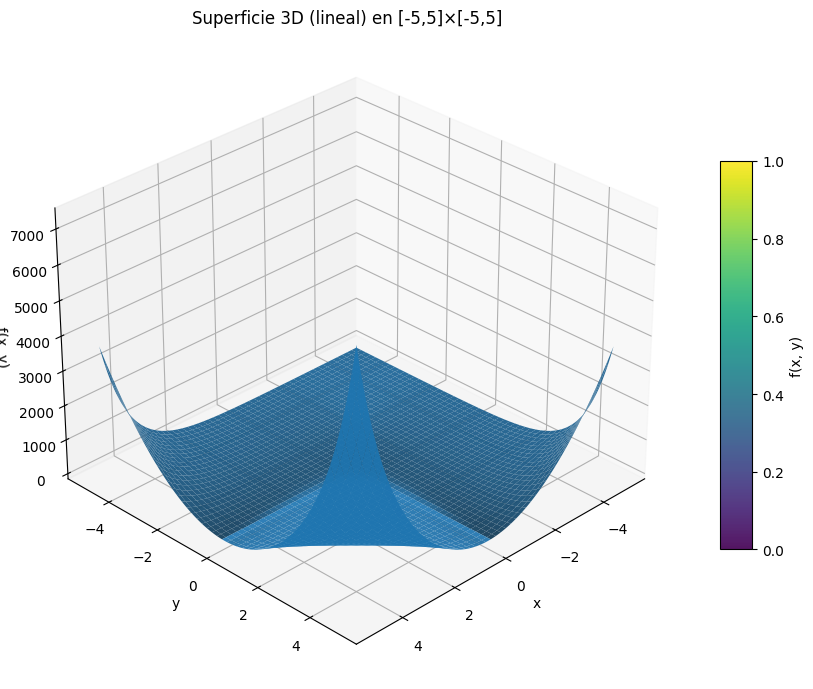

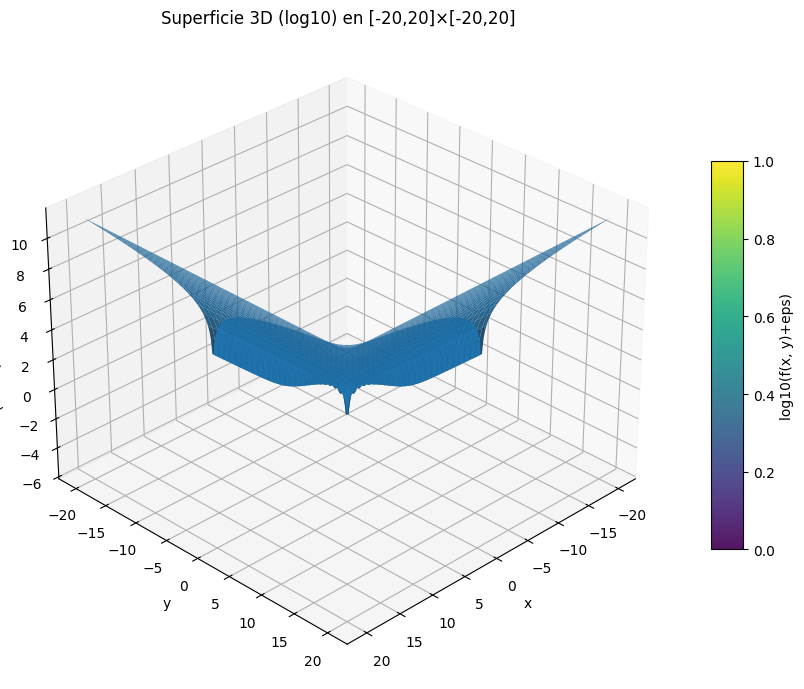

'./figs/f_surface_log10_[-20,20].png'

In [87]:

def plot_function_3d(x_min=-5, x_max=5, y_min=-5, y_max=5, n=200,
                     elev=30, azim=45, mode="linear", eps=1e-12,
                     filename=None, show=True):
    xs = np.linspace(x_min, x_max, n)
    ys = np.linspace(y_min, y_max, n)
    X, Y = np.meshgrid(xs, ys)
    if mode == "linear":
        Z = f(X, Y)
        zlabel = "f(x, y)"
        title = f"Superficie 3D (lineal) en [{x_min},{x_max}]×[{y_min},{y_max}]"
    elif mode == "log10":
        Z = np.log10(f(X, Y) + eps)
        zlabel = "log10(f(x, y)+eps)"
        title = f"Superficie 3D (log10) en [{x_min},{x_max}]×[{y_min},{y_max}]"
    else:
        raise ValueError("mode must be 'linear' or 'log10'")
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, edgecolor='none', alpha=0.92)
    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=12, label=zlabel)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(zlabel)
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=180)
    if show:
        plt.show()
    else:
        plt.close(fig)
    return filename

# Vista lineal cercana al origen (forma real)
plot_function_3d(x_min=-5, x_max=5, y_min=-5, y_max=5, mode="linear",
                 filename=f"./figs/f_surface_linear_[-5,5].png", show=True)

# Vista log10 en ventana amplia (órdenes de magnitud)
plot_function_3d(x_min=-20, x_max=20, y_min=-20, y_max=20, mode="log10",
                 filename=f"./figs/f_surface_log10_[-20,20].png", show=True)



## 2. Algoritmos: descenso por gradiente y Newton amortiguado

Usamos versiones simples con **búsqueda de paso** (backtracking). Para Newton, añadimos una **amortiguación** tipo Levenberg–Marquardt: $H_\lambda = H + \lambda I$.


Descenso por gradiente con búsqueda de paso  
La idea es moverse, en cada iteración, en la dirección opuesta al gradiente porque a primer orden es la dirección que más reduce la función. El tamaño del paso no se fija de antemano: se prueba un tamaño inicial y, si no consigue una reducción suficiente, se recorta repetidamente hasta aceptar un paso que baje la función (regla tipo Armijo). Se detiene cuando la norma del gradiente es menor que un umbral o cuando se alcanza el número máximo de iteraciones.  
Parámetros: alpha0 (tamaño inicial de paso), rho (factor de recorte del paso), c (constante de Armijo que fija cuánta bajada se exige), tol (tolerancia para la norma del gradiente), maxit (límite de iteraciones), max_bt si se usa límite de recortes.

Newton amortiguado con búsqueda de paso  
La idea es usar gradiente y curvatura: se resuelve un sistema lineal con el hessiano regularizado para proponer un salto que minimiza un modelo cuadrático local; esa regularización (amortiguación) estabiliza cuando la curvatura es mala. El paso propuesto también pasa por una búsqueda de paso que sólo acepta movimientos que reduzcan la función; si ningún tamaño sirve, se aumenta la amortiguación y se vuelve a intentar. Se detiene cuando la norma del gradiente es menor que un umbral o al alcanzar el máximo de iteraciones.  
Parámetros: lambda0 (amortiguación inicial del hessiano), alpha0 (tamaño inicial de paso), rho (factor de recorte), c (constante de Armijo), tol (tolerancia para la norma del gradiente), maxit (límite de iteraciones), max_bt si se limita el número de recortes.


In [88]:

def backtracking(xy, d, fval, grad_xy, alpha0=1.0, rho=0.5, c=1e-4, max_bt=30):
    # Regla de Armijo (backtracking) básica
    x, y = xy
    gTd = grad_xy @ d
    alpha = alpha0
    for _ in range(max_bt):
        xn, yn = x + alpha*d[0], y + alpha*d[1]
        fn = f(xn, yn)
        if fn <= fval + c*alpha*gTd:
            return alpha, fn, np.array([xn, yn])
        alpha *= rho
    return 0.0, fval, np.array([x, y])

def gd_with_linesearch(xy0, tol=1e-8, maxit=3000, alpha0=1.0):
    path = [np.array(xy0, dtype=float)]
    fvals = [f(*xy0)]
    for k in range(maxit):
        x, y = path[-1]
        g = grad(x, y)
        gn = np.linalg.norm(g)
        if gn < tol:
            return {"name":"GD", "success":True, "k":k, "xy":(x,y), "f":fvals[-1],
                    "grad_norm":gn, "path":np.array(path), "fvals":np.array(fvals)}
        d = -g
        alpha, fn, xnyn = backtracking(np.array([x,y]), d, fvals[-1], g, alpha0=alpha0)
        if alpha == 0.0:
            return {"name":"GD", "success":False, "k":k, "xy":(x,y), "f":fvals[-1],
                    "grad_norm":gn, "path":np.array(path), "fvals":np.array(fvals),
                    "reason":"no_step"}
        path.append(xnyn)
        fvals.append(fn)
    return {"name":"GD", "success":False, "k":maxit, "xy":tuple(path[-1]), "f":fvals[-1],
            "grad_norm":np.linalg.norm(grad(*path[-1])), "path":np.array(path),
            "fvals":np.array(fvals), "reason":"maxit"}

def newton_damped(xy0, tol=1e-8, maxit=1000, lambda0=1e-4, alpha0=1.0):
    path = [np.array(xy0, dtype=float)]
    fvals = [f(*xy0)]
    lam = lambda0
    for k in range(maxit):
        x, y = path[-1]
        g = grad(x, y)
        gn = np.linalg.norm(g)
        if gn < tol:
            return {"name":"NewtonD", "success":True, "k":k, "xy":(x,y), "f":fvals[-1],
                    "grad_norm":gn, "path":np.array(path), "fvals":np.array(fvals),
                    "lambda":lam}
        H = hess(x, y) + lam*np.eye(2)
        try:
            d = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            return {"name":"NewtonD", "success":False, "k":k, "xy":(x,y), "f":fvals[-1],
                    "grad_norm":gn, "path":np.array(path), "fvals":np.array(fvals),
                    "lambda":lam, "reason":"singular"}
        alpha, fn, xnyn = backtracking(np.array([x,y]), d, fvals[-1], g, alpha0=alpha0)
        if alpha == 0.0:
            lam *= 10.0
            continue
        path.append(xnyn)
        fvals.append(fn)
        lam = max(lambda0, lam/2.0)
    return {"name":"NewtonD", "success":False, "k":maxit, "xy":tuple(path[-1]), "f":fvals[-1],
            "grad_norm":np.linalg.norm(grad(*path[-1])), "path":np.array(path),
            "fvals":np.array(fvals), "lambda":lam, "reason":"maxit"}



## 3. Experimentos y guardado en JSON

Por defecto ejecutamos **N=400** experimentos aleatorios


In [89]:

rng = np.random.default_rng(12345)

def run_suite(N=400, a=100.0, tol=1e-8,
              gd_params=dict(tol=1e-8, maxit=3000, alpha0=1.0),
              nd_params=dict(tol=1e-8, maxit=1000, lambda0=1e-4, alpha0=1.0)):
    starts = rng.uniform(-a, a, size=(N,2))
    records = []
    for i, (x0, y0) in enumerate(starts):
        r_gd = gd_with_linesearch((x0,y0), **gd_params)
        r_nd = newton_damped((x0,y0), **nd_params)
        def summarize(res):
            path = res["path"]
            diffs = np.diff(path, axis=0) if len(path)>1 else np.zeros((0,2))
            path_len = float(np.sum(np.linalg.norm(diffs, axis=1)))
            max_abs = float(np.max(np.abs(path))) if len(path)>0 else float('nan')
            end = path[-1] if len(path)>0 else np.array([x0,y0])
            val = float(res["f"])
            cat = "other"
            if np.linalg.norm(end) < 5.0 and val < 1e-6:
                cat = "origin_near"
            if (end[0] < -150 or end[1] < -150) and val < 1e-9:
                cat = "neg_plateau"
            return dict(
                name=res["name"],
                success=bool(res.get("success", False)),
                k=int(res.get("k", 0)),
                f=val,
                grad_norm=float(res.get("grad_norm", np.nan)),
                path_len=path_len,
                max_abs=max_abs,
                end_x=float(end[0]), end_y=float(end[1]),
                category=cat,
                reason=res.get("reason", ""),
                lam=float(res.get("lambda", np.nan))
            )
        rec = dict(
            start=[float(x0), float(y0)],
            gd=summarize(r_gd),
            newton=summarize(r_nd)
        )
        records.append(rec)
    payload = dict(params=dict(N=N, a=a, tol=tol), results=records)
    out_json = os.path.join("./data", f"results_N{N}.json")
    with open(out_json, "w") as fjson:
        json.dump(payload, fjson, indent=2)
    print(f"Guardado: {out_json}")
    return payload, out_json

payload, json_path = run_suite(N=400)
json_path


/tmp/ipykernel_599367/4294352495.py:13: RuntimeWarning: overflow encountered in exp
  return (x**2)*np.exp(y) + (y**2)*np.exp(x)
/tmp/ipykernel_599367/4294352495.py:13: RuntimeWarning: overflow encountered in scalar multiply
  return (x**2)*np.exp(y) + (y**2)*np.exp(x)


Guardado: ./data/results_N400.json


'./data/results_N400.json'


## 4. Análisis de resultados y casos críticos


In [90]:

import pandas as pd

with open(json_path, "r") as fjson:
    data = json.load(fjson)
rows = []
for rec in data["results"]:
    sx, sy = rec["start"]
    for key in ("gd", "newton"):
        r = rec[key]
        rows.append(dict(
            algo=key, start_x=sx, start_y=sy,
            success=r["success"], k=r["k"], f=r["f"], grad_norm=r["grad_norm"],
            path_len=r["path_len"], max_abs=r["max_abs"], end_x=r["end_x"], end_y=r["end_y"],
            category=r["category"], reason=r["reason"], lam=r.get("lam", float('nan'))
        ))
df = pd.DataFrame(rows)

def summary_table(df, algo):
    sub = df[df["algo"]==algo]
    def pct(x): return 100.0*len(x)/len(sub) if len(sub)>0 else np.nan
    tab = {
        "N casos": len(sub),
        "Éxito (%)": 100.0*np.mean(sub["success"]) if len(sub)>0 else np.nan,
        "k mediana": float(np.median(sub["k"])) if len(sub)>0 else np.nan,
        "k [P25, P75]": (float(np.percentile(sub["k"],25)), float(np.percentile(sub["k"],75))) if len(sub)>0 else (np.nan,np.nan),
        "f mediana": float(np.median(sub["f"])) if len(sub)>0 else np.nan,
        "||g|| mediana": float(np.median(sub["grad_norm"])) if len(sub)>0 else np.nan,
        "long. camino mediana": float(np.median(sub["path_len"])) if len(sub)>0 else np.nan,
        "max_abs mediana": float(np.median(sub["max_abs"])) if len(sub)>0 else np.nan,
        "cat origin_near (%)": pct(sub[sub["category"]=="origin_near"]),
        "cat neg_plateau (%)": pct(sub[sub["category"]=="neg_plateau"]),
        "fallo no_step/maxit (%)": pct(sub[(~sub["success"]) & (sub["reason"].isin(["no_step","maxit"]))]),
    }
    return pd.Series(tab)

display(summary_table(df, "gd").to_frame("GD"))
display(summary_table(df, "newton").to_frame("Newton amortiguado"))


,GD
N casos,400
Éxito (%),22.25
k mediana,0.0
"k [P25, P75]","(0.0, 1.0)"
f mediana,92366401546708156416.0
||g|| mediana,92808215691641012224.0
long. camino mediana,0.0
max_abs mediana,75.140882
cat origin_near (%),0.25
cat neg_plateau (%),7.0


,Newton amortiguado
N casos,400
Éxito (%),35.0
k mediana,1000.0
"k [P25, P75]","(91.0, 1000.0)"
f mediana,0.0
||g|| mediana,0.0
long. camino mediana,61.795776
max_abs mediana,69.505577
cat origin_near (%),20.0
cat neg_plateau (%),0.0


## Análisis conciso de resultados (N = 400)

## Descenso por gradiente (GD)

La tasa de éxito del 22.25%, junto con k mediana = 0 y longitud de camino = 0, indica que la mayoría de los “éxitos” siguen siendo triviales: el criterio de parada se satisface en el punto inicial porque la norma del gradiente ya es menor que el umbral, fenómeno típico de zonas superplanas en el tercer cuadrante.

En los casos restantes, la f mediana ≈ 9.24×10^19 y la ‖g‖ mediana ≈ 9.28×10^19 señalan que, cuando no arranca en una región plana, el método enfrenta escala muy grande y no progresa. Esto se ve reforzado por el 77.75% de fallos *no_step/maxit*, reflejando que la búsqueda de paso recorta hasta no aceptar o se agotan iteraciones.

Las categorías origin_near = 0.25% y neg_plateau = 7.0% muestran que prácticamente no alcanza el entorno del origen y muy raramente aterriza en la meseta negativa: o bien se declara listo sin moverse, o bien se estanca.

## Newton amortiguado

La tasa de éxito del 35.0% y la longitud de camino mediana ≈ 61.8 evidencian que el método se desplaza y reduce *f* con mayor frecuencia que GD. Sin embargo, la k mediana = 1000 con [P25,P75] = (91.0, 1000.0) indica que al menos la mitad de los casos topa el límite de iteraciones, es decir, realiza progreso pero no alcanza el criterio antes del tope.

En el agregado, f mediana = 0 y ‖g‖ mediana = 0 sugieren que una fracción relevante aterriza en regiones donde *f* y el gradiente son prácticamente nulos (o llegan a escala numérica), coherente con trayectorias hacia zonas muy “frías”. La categoría origin_near = 20.0% muestra que en uno de cada cinco arranques sí alcanza la vecindad del mínimo. La etiqueta neg_plateau = 0% obedece a los umbrales de clasificación y al tamaño de la ventana: pueden existir finales con valores ínfimos que no superan el corte geométrico (p. ej., no alcanzan x o y < −150).

## Conclusión

GD presenta éxitos mayormente por condición inicial (gradiente ya pequeño) y fracasa cuando la escala de *f* y ‖g‖ es grande: carece de tracción efectiva fuera de las mesetas.

Newton amortiguado muestra mejor capacidad de reducción y de llegada al entorno del origen, pero su rendimiento queda limitado por el tope de iteraciones y por una condición de Armijo estricta en regiones de gran planitud.


In [91]:

# Outliers por IQR en iteraciones y en max_abs
def iqr_outliers(s):
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    lo = q1 - 1.5*iqr
    hi = q3 + 1.5*iqr
    mask = (s < lo) | (s > hi)
    return mask, (lo, hi)

for metric in ["k", "max_abs"]:
    print(f"\nOutliers por IQR en {metric}:")
    for algo in ["gd", "newton"]:
        sub = df[df["algo"]==algo]
        mask, (lo, hi) = iqr_outliers(sub[metric].values)
        outs = sub[mask]
        print(f"  {algo}: {len(outs)} casos (umbral [{lo:.2f},{hi:.2f}])")



Outliers por IQR en k:
  gd: 69 casos (umbral [-1.50,2.50])
  newton: 0 casos (umbral [-1272.50,2363.50])

Outliers por IQR en max_abs:
  gd: 43 casos (umbral [-11.55,154.06])
  newton: 0 casos (umbral [-11.67,145.22])


/tmp/ipykernel_599367/577735479.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([df[df["algo"]=="gd"][metric], df[df["algo"]=="newton"][metric]], labels=["GD","NewtonD"])
/tmp/ipykernel_599367/577735479.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([df[df["algo"]=="gd"][metric], df[df["algo"]=="newton"][metric]], labels=["GD","NewtonD"])
/tmp/ipykernel_599367/577735479.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot([df[df["algo"]=="gd"][metric], df[df["algo"]=="newton"][metric]], labels=["GD","NewtonD"])


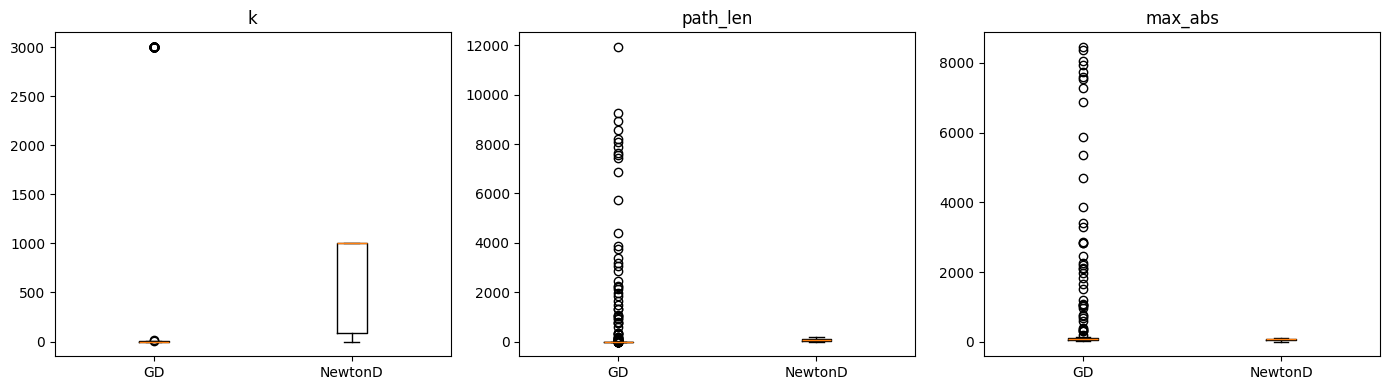

In [92]:

# Figuras comparativas básicas
fig, axes = plt.subplots(1, 3, figsize=(14,4))
for i, metric in enumerate(["k","path_len","max_abs"]):
    axes[i].boxplot([df[df["algo"]=="gd"][metric], df[df["algo"]=="newton"][metric]], labels=["GD","NewtonD"])
    axes[i].set_title(metric)
plt.tight_layout()
plt.savefig("./figs/comparacion_boxplots.png", dpi=180)
plt.show()


In [93]:

# Distribución de categorías
cats = df.groupby(["algo","category"]).size().reset_index(name="count")
pivot = cats.pivot(index="algo", columns="category", values="count").fillna(0).astype(int)
pivot


category,neg_plateau,origin_near,other
algo,,,
gd,28,1,371
newton,0,80,320


  
- Outliers en `k` (GD) → estancamiento en zonas planas o “éxitos” por criterio sin movimiento real.  
- Outliers en `max_abs` (Newton) → rutas que apuntan a regiones con exponenciales grandes (riesgo de desborde si el paso no se recorta).  
- `origin_near` vs `neg_plateau` separa finales cerca del origen de finales “muy negativos con $f$ minúscula”. Es normal que Newton acumule `neg_plateau` cuando parte de cuadrantes “calientes”.



## 5. Experimentos adicionales



### 5.1. Mapa de “basins” (pequeño grid)


/tmp/ipykernel_599367/4294352495.py:13: RuntimeWarning: overflow encountered in exp
  return (x**2)*np.exp(y) + (y**2)*np.exp(x)


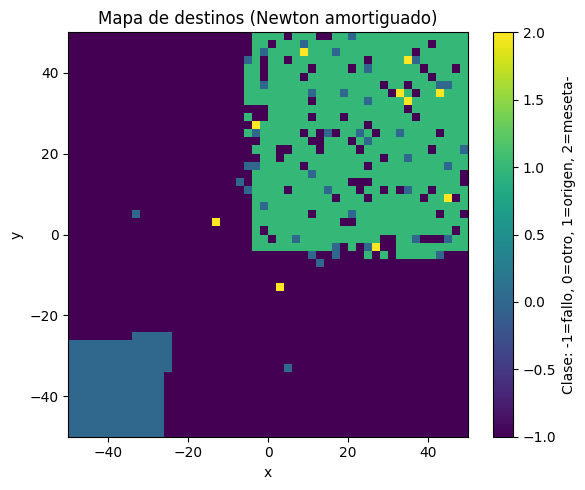

In [94]:

def classify_endpoint(xy, tol=1e-8):
    res = newton_damped(xy, tol=tol, maxit=400, lambda0=1e-4, alpha0=1.0)
    end = np.array([res["xy"][0], res["xy"][1]])
    val = float(res["f"])
    if np.linalg.norm(end) < 5.0 and val < 1e-6:
        return 1  # origen
    if (end[0] < -150 or end[1] < -150) and val < 1e-9:
        return 2  # meseta negativa
    return 0 if res["success"] else -1

xs = np.linspace(-50, 50, 50)
ys = np.linspace(-50, 50, 50)
B = np.zeros((len(ys), len(xs)), dtype=int)
for i, y in enumerate(ys):
    for j, x in enumerate(xs):
        B[i,j] = classify_endpoint((float(x), float(y)))

plt.figure(figsize=(6,5))
plt.imshow(B, origin="lower", extent=[xs.min(), xs.max(), ys.min(), ys.max()], aspect="auto")
plt.colorbar(label="Clase: -1=fallo, 0=otro, 1=origen, 2=meseta-")
plt.title("Mapa de destinos (Newton amortiguado)")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.savefig("./figs/basins_small.png", dpi=180)
plt.show()


### Mapa de basins:

Un mapa de basins (o mapa de destinos) colorea el plano de inicios según el **punto al que termina** un algoritmo al optimizar. Cada celda representa un punto de partida y su color indica la **clase de destino**: fallo (−1), final “otro” (0), vecindad del origen (1) o meseta negativa (2).

En este problema, el mapa permite **visualizar la geometría práctica** de la función frente a Newton amortiguado: la zona verde muestra inicios que **convergen al origen**, mientras que las manchas amarillas representan **trayectorias que huyen** hacia regiones muy negativas donde *f* es casi nula. El bloque morado en el tercer cuadrante corresponde a **fallos de paso** en zonas superplanas: el método no acepta pasos por la condición de descenso, aunque *f* ya sea diminuta.

Su utilidad es doble: describe **qué regiones del plano “pertenecen” a cada destino** y revela **sensibilidades del algoritmo** (por ejemplo, dependencias del criterio de paso en áreas planas, o cómo la curvatura empuja hacia la meseta). En conjunto, el mapa resume de forma visual por qué Newton acierta cerca del origen y, en otros casos, prefiere itinerarios que llevan a valores prácticamente cero lejos de él.
